<div style="text-align:center">
  <h1>Reducing Estimation Errors in Forecast Combination: Covariance Matrix Estimation and Trimming Methods</h1>
  <h3>Yannick van Etten (2688877)</h3>
  <h3>Bachelor Thesis Econometrics and Operations Research</h3>
  <h3>Thesis commission: Dr. L. Hoesch  (supervisor) and Xia Zou  (co-reader)</h3>
</div>


<div style="text-align:center">
  <h4>Simulation study Radchenko et al. (2023)</h4>
</div>

This Jupyter Notebook is part of the bachelor thesis by Yannick van Etten. Several methods are evaluated to reduce the estimation errors. In the previous Notebook the trimming method of Radchenko et al. (2023) was evaluated and replicated. This Notebook focusses on the performance of different covariance estimation methdods. Specially, the linear shrinkage method and the factor model method. These methods are evaluated on the hand of the mean squared forecasting error (MSFE) of a forecast combination. The trimming method is applied on the weights obtain by the usage of these alternative covariance estimation methods.

This Notebook starts with theory and general functions used in the simulation are discussed. The setting of the simulation is similar to the replicated setting of Radchenko et al. (2023), so some parts/functions will coincide. However, instead of two forecasts, 25 forecasts are available. The number of forecasters is increased to create a more similar high dimensional setting where the number of forecasts is similar to the number of observations. This setting resembles the empirical application of Radchenko et al. (2023). 

In the simulation study the influence of the shrinkage factor in the linear shrinkage method on the MSFE is determined in a simulation study in a high dimensional setting. A optimal shrinkage value is picked. Therafter, the MSFE function conditional on the trimming threshold is calculated and plotted. This MSFE function is determined three times, each time using a different covariance estimation method. Starting, with the usual sample covariance estimation method. Following, the linear shrinkage method. Lastly, the factor model method.


In [61]:
import numpy as np
import matplotlib.pyplot as plt

<div style="text-align:center">
  <h3>General theory and functiond for the simulation study</h3>
</div>

In this simulation study, a time series is generated based on an AR(1) process:
$$
z_t = \phi_1 z_{t-1}+\eta_t \quad\quad t=1,\dots,T+1
$$
The error ${\eta_t}$ are independent and identically distributed from a standard normal distribution. The parameter $\phi_1$ is chosen to satisfy $|\phi_1|<1$. In total $n$ time series will be generated. To improve the efficiency of the simulation this done in one time, to create one matrix contraining all the timeseries of length $T+1$.

The aim is to have the same number of available error observations as in Radchenko et al. (2023) to estimate the covariance matrix using forecast errors. In their study, 28 error observations were available with sample size $T = 30$, considering the use of $z_{t-2}$ for the $y_2$ forecast. In our simulation, $z_{t-25}$ is used, so to ensure 28 error observations for all forecasts, the sample size $T$ is set at $T= 28 + 25 = 53$.

In [142]:
def simulate_ar1(phi, T, n, n_forecasts):
    """
    Simulates an autoregressive process of order 1 (AR(1)). 

    Input:
        phi (float): The autoregressive coefficient.
        T (int): The number of observations used to estimate the weights used in the forecast combination for T+1.
        n (int): The number of simulations.
        n_forecasts (int): The number of forecasts. Previously this was two.

    Returns:
        ar (ndarray): A numpy array of shape (n, T + n_forecasts - 1) containing the simulated AR(1) process.

    """
    ar = np.zeros((n, T + n_forecasts - 1))  # Create an array to store the simulated process
    seed_value = 777
    np.random.seed(seed_value)  # Set a seed value for reproducibility
    ar[:, 0] = np.random.normal(0, 1, size=n)  # Set initial values from a standard normal distribution

    for t in range(1, T + n_forecasts - 1):
        ar[:, t] = phi * ar[:, t - 1] + np.random.normal(0, 1, size=n)  # Generate AR(1) values for each time period

    return ar

The auto-correlation coefficient function $\rho_i$ is defined as the correlation between observations $z_t$ and $z_{t-i}$, given by:
\begin{align*}
    \rho_i &= \text{corr}(z_t,z_{t-i}) = \phi_1^i
\end{align*}
In the previous simulation study, only the values of $\rho_1$ and  $\rho_2$ were provided and used to generate the first two forecasts:
\begin{align*}
    y_1 &= z_T && \quad\quad\quad y_2 = \rho_2 z_{T-1}
\end{align*}
However, in this current simulation study, 23 additional forecasts are included. These additional forecasts, denoted as $y_i$ for $i\in {3, \dots, 25}$, are based on the unbiased forecast $y_2$. Specifically, the formula for generating these additional forecasts is:
\begin{align*}
    y_i &=  \rho_i z_{T-i}
\end{align*}

Given these characteristic, it is possible to determine the true covariance matrix of the forecast errors. This way the estimated covariance matrices can be evaluated by determining the difference. The true covariance matrix

Since forecasts $2$ till $25$ have a same unbiased property, they also have a similar forecast error variance structure. The properties of forecast $1$ and forecasts $i\in{2,\dots,25}$ will be explicitly examined. All the derivations are written out in the appendix. The forecast $1$ has an error of $e_{1t}=z_t-z_{t-1}$ and the additional forecasts have an error of $e_{it}=z_t-\rho_i$ for $i\in{2,\dots,25}$. The final forecast error are:
\begin{align*}
    e_1 &= e_{1,T+1}=z_{T+1}-y_1 && \quad\quad\quad e_i = e_{i,T+1}=z_{T+1}-y_i\\
    e_1 &=z_{T+1}-z_T && \quad\quad\quad e_i=z_{T+1}-\rho_i z_{T-i}
\end{align*}
This leads to the following forecast error variances:
\begin{align*}
    \sigma_1^2 &= \text{var}(e_1)=2(1-\rho_1)\sigma_z^2 && \sigma_i^2 = \text{var}(e_i)=(1-\rho_i^2)\sigma_z^2
\end{align*}
Since there are two types of forecasts, namely $y_1$ and the unbiased forecasts $y_i$ for $i\in{2,\dots,25}$, there are two formulas to determine the true covariance. The first formula calculates covariance between forecast error $e_1$ and the forecast error $e_i$ of an unbiased forecast, given by:
$$
\text{cov}(e_1,e_i)=\sigma_z^2 (1 - \rho_1 -\rho_i^2  + \rho_i \rho_{i-1})
$$
The second formula calculates the covariance between error of two unbiased forecasts, where $i,j>1$ and $i\le j$, given by:
$$
\text{cov}(e_i,e_j)= \sigma_z^2(1 -\rho_i^2 - \rho_j^2 + \rho_i\rho_j\rho_{j-i})
$$

In [143]:
def calc_true_cov(phi, n_forecasters):
    """
    Calculates the true covariance matrix for a given autoregressive coefficient and number of forecasters.

    Input:
        phi (float): The autoregressive coefficient.
        n_forecasters (int): The number of forecasters.

    Returns:
        true_cov (ndarray): A numpy array of shape (n_forecasters, n_forecasters) containing the true covariance matrix.

    """
    sigma2_z = 1 / (1 - phi**2)  # Calculate the variance of the AR(1) process
    true_cov = np.zeros((n_forecasters, n_forecasters))  # Create an array to store the true covariance matrix

    # Calculate the diagonal elements of the covariance matrix
    true_cov[0, 0] = 2 * (1 - phi) * sigma2_z
    for i in range(1, n_forecasters):
        k = i + 1            # to adjust for index
        true_cov[i, i] = (1 - phi**(2*k)) * sigma2_z

        # Calculate the off-diagonal elements of the covariance matrix
        true_cov[i, 0] = sigma2_z * (1 - phi - phi**(2*i) + phi**i * phi)
        true_cov[0, i] = true_cov[i, 0]

        for j in range(i + 1, n_forecasters):
            l = j + 1  # again to adjust for index
            true_cov[j, i] = sigma2_z * (1 - phi**(2*k) - phi**(2*l) + phi**k * phi**(l) * phi**(abs(k - l)))
            true_cov[i, j] = true_cov[j, i]
    return true_cov

Before it is possible to estimate the covariance matrix. It is necessary to calculate the forecast erros, since the matrices are based on these errors. In the following function a list with forecasts for $z_{T+1}$, a list with previous forecasts, a list with the forecast error for alle forecasts and a matrix mu with the true $z_{T+1}$ are all determined.

In [144]:
def calc_forecast_errors(z, rho, n_forecasters):
    """
    Calculates the forecast errors for a given time series, autocorrelation coefficient and the number of forecasters.

    Input:
        z (ndarray): A numpy array of shape (n, T+n_forecasts-1) representing the time series.
        rho (float): The autocorrelation coefficient.
        n_forecasters (int): The number of forecasters.

    Returns:
        y_all (list): A list of numpy arrays containing the forecasts for z_T+1.
        Y_all (list): A list of numpy arrays containing the previous forecasts for all forecaster.
        errors (list): A list of numpy arrays representing the forecast errors for each forecaster.
        mu (ndarray): A numpy array of shape (n, n_forecasts) containing the true values at T+1 to be forecasted

    """
    phi = -1 * np.sqrt(rho)  # Calculate the AR(1) coefficient based on the given autocorrelation coefficient
    z_copy = z.copy()
    remove = np.arange(n_forecasters - 1)  # Indices to remove from the time series

    VY1 = np.delete(z_copy, remove, axis=1)  #to make sure we have the same number of forecasts to evaluate
    mu = z[:, n_forecasters:]    # Extract the true values to be forecasted

    errors = []  # List to store the forecast errors for each forecaster
    Y_all = []  # List to store the previous forecasts for each forecaster
    y_all = []  # List to store the forecasts for T+1

    y_all.append(VY1[:, -1])  # Append the T+1 forecast to the list for the first forecast
    VY1 = np.delete(VY1, -1, axis=1)  # Remove the T+1 forecast from the time series

    errors.append(mu - VY1)  # Calculate the forecast errors at the T+1 for the first forecast
    Y_all.append(VY1)

    for i in range(1, n_forecasters): 
        VY = phi**(i + 1) * z[:, (n_forecasters - 1 - i):-i]  # Generate the forecasts for each forecaster 2 till 25
        y_all.append(VY[:, -1])  # Append the T+1 forecast to the list
        VY = np.delete(VY, -1, axis=1)  # Remove the T+1 forecast from the time series
        errors.append(mu - VY)  # Calculate the forecast errors for each forecaster
        Y_all.append(VY)

    return y_all, Y_all, errors, mu

On the hand of the covariance matrix, the weights for the forecast combination can be calculated. The variance of the forecast combination is given by:
$$
\text{var}(y_c)=w'\Sigma w
$$
This variance is minimized, resulting in the optimal weights:
\begin{equation}
w^*=\frac{\Sigma^{-1}}{\mathbf{1}'\Sigma^{-1}\mathbf{1}}
\end{equation}
where $\mathbf{1}$ represents a vector of ones. To determine the theoretical optimal weights, the true covariance in inserted. The estimated covariance estimate can also be used, resulting in estimated optimal weights.

In [145]:
def calc_cov_w(Mcov):
    """
    Calculates the covariance matrix of the weight vectors.

    Input:
        Mcov (ndarray): A square numpy array of shape (n_forc, n_forc) representing the covariance matrix of forecast errors.

    Returns:
        cov_w (ndarray): A square numpy array of shape (n_forc, n_forc) representing the covariance matrix of the weight vectors.
    """
    n_forc = len(Mcov)
    cov_inv = np.linalg.inv(Mcov)  # Calculate the inverse of the covariance matrix
    ones = np.ones(n_forc).reshape(-1, 1)  # Create a column vector of ones
    w = 1 / float(ones.T @ (cov_inv @ ones)) * cov_inv @ ones  # Calculate the weight vector
    return w

The covariance matrix is estimated with three different methods. The first method is the sample covariance method. This method is similar to the method used in Radchenko et al. (2023). But extended to 25 forecasts. The error means are calculates as: $\overline{e_i}=\frac{1}{T-25}\sum\nolimits^{T-1}_{t=25}e_{1,t+1}$. All necessary tools are now present to determine the sample covariance matrix,$\widehat{\Sigma}_{sample}$ by:
\begin{align*}
\widehat{\Sigma}_{sample} &=
    \begin{pmatrix}
    \widehat{\sigma}_1^2 & \widehat{\rho}_{12}\widehat{\sigma}_1\widehat{\sigma}_2& \dots &\widehat{\rho}_{1,25}\widehat{\sigma}_1\widehat{\sigma}_{25} \\
    \widehat{\rho}\widehat{\sigma}_1\widehat{\sigma}_2 & \widehat{\sigma}_2^2& &\\
    \vdots & &\ddots & \vdots\\
    \widehat{\rho}_{1,25}\widehat{\sigma}_1\widehat{\sigma}_{25}& \dots & & \widehat{\sigma}_{25}^2
    \end{pmatrix} \\
    &= \frac{1}{T-26}\times \sum\limits^{T-1}_{t=25} 
    \begin{pmatrix}
    (e_{1,t+1}-\overline{e_1})^2 & (e_{1,t+1}-\overline{e_1})(e_{2,t+1}-\overline{e_2}) &\dots\\
    (e_{1,t+1}-\overline{e_1})(e_{2,t+1}-\overline{e_2}) & (e_{2,t+1}-\overline{e_2})^2&\\
    \vdots & & \ddots
    \end{pmatrix}
\end{align*}

In the function were the sample covariance matrix is estimated, the estimated optimal weights are calculated at the same time.

In [146]:
def est_cov_sample(Merror):
    """
    Estimates the sample covariance matrix of the forecast errors.

    Input:
        Merror (list): A list of numpy arrays, each representing the forecast errors for a forecaster.

    Returns:
        Mcov (ndarray): A square numpy array of shape (n_forecasters, n_forecasters) representing the estimated
                        covariance matrix of forecast errors.
        Vw (ndarray): A numpy array of shape (n_forecasters, n_forecasters) containing the weight vectors.

    """
    T = len(Merror[0][0])   # the length of the error vector of the forecasts
    
    Vp = []
    Mcov = np.array(np.zeros((len(Merror), len(Merror))), dtype=object)

    for i in range(len(Merror)): # Iterate over each forecast
        et = Merror[i]
        e_bar = np.mean(et, axis=1)

        # Calculate the diagonal element of the covariance matrix
        Mcov[i, i] = np.sum(np.power(et - e_bar[:, np.newaxis], 2), axis=1) / (T - 1)
        Vp.append(et - e_bar[:, np.newaxis]) # Compute the residuals and store them in the list

        for j in range(i):
            Mcov[i, j] = np.sum(Vp[i] * Vp[j], axis=1) / (T - 1) # Calculate the off-diagonal covariance elements
            Mcov[j, i] = Mcov[i, j]  # by symmetry

    Vw = np.empty((0, len(Merror)))

    for k in range(len(Merror[0])): # Iterate over each specific forecast
        Mcov2 = np.array(np.zeros((len(Merror), len(Merror))))

        for i in range(len(Merror)):
            Mcov2[i, i] = Mcov[i, i][k]

            for j in range(i):
                Mcov2[i, j] = Mcov[i, j][k]
                Mcov2[j, i] = Mcov2[i, j]
        w2 = calc_cov_w(Mcov2) # Calculate the est opt weights using the covariance matrix
        Vw = np.vstack((Vw, w2.T))
        
    return Mcov, Vw

A second method to determine the covariance matrix, is the linear shrinkage methods. In this setting the following linear shrinkage estimator, $\widehat{\Sigma}_{LS}$, is determined by:
$$
\widehat{\Sigma}_{LS} = \delta \widehat{\mu}_p I_p + (1-\delta) \widehat{\Sigma}_{sample}
$$
As stated in the thesis, the paper of Ledoit and Wolf (2004) is followed for the estimation of parameter $\mu_p$, with $\widehat{\mu}_p=\langle \widehat{\Sigma}_{sample},I_p \rangle$. In this calculation $\delta$ is defined as the shrinkage coefficient, or the shrinkage intensity. If $\delta \approx 1$, it means that the identity matrix is fully utilized and the sample covariance matrix has minimal influence. On the other hand, if $\delta \approx 0$, the original sample covariance matrix is used without much influence of the identity matrix.

In [147]:
def est_cov_shrinkage(sample_covariance, shrink_value):
    """
    Estimates the covariance matrix with the linear shrinkage method.

    Input:
        sample_covariance (ndarray): A square numpy array of shape (n_forecasters, n_forecasters) representing the sample covariance matrix.
        shrink_value (float): The shrinkage coefficient.

    Returns:
        shrinkage_covariance (ndarray): A square numpy array of shape (n_forecasters, n_forecasters) representing the estimated covariance matrix with shrinkage.
        w (ndarray): A numpy array of shape (n_forecasters, 1) representing the weights calculated from the shrinkage covariance matrix.
    """
    n_forecasters = len(sample_covariance)
    
    diag_elements = np.diag(sample_covariance)  # Extract diagonal elements from the sample covariance matrix
    m_star = np.mean(diag_elements)  # Calculate the mean of the diagonal elements
    shrinkage_covariance = (
        shrink_value * np.eye(n_forecasters) * m_star
        + (1 - shrink_value) * sample_covariance
    )  # Estimate the covariance matrix with shrinkage

    w = calc_cov_w(shrinkage_covariance)  # Calculate the weights based on the shrinkage covariance matrix

    return shrinkage_covariance, w

The third covariance matrix estimation method is the factor model. In this approach, the number of factors is set equal to the number of forecasts, 25. The factor loadings are determined through the singular value decomposition of the matrix consisting of the estimation errors for all forecasts. Using the factor loadings, the factor variances can be estimated, leading to an estimation of the factor covariance matrix, denoted as $\widehat{\Sigma}_{factor}$. A detailed description of the factor model can be found in the thesis.

In [148]:
def est_cov_factor(Merror):
    """
    Estimate the covariance matrix using factor models.

    Input:
        Merror (list of arrays): List of forecast errors from different forecasters.
        T (int): Number of observations.

    Returns:
        tuple: A tuple containing the estimated covariance matrix and the weight matrix.

    """
    n_forecasters = len(Merror)
    n_factors = n_forecasters  # Use the same number of factors as forecasters

    # Compute the factor loadings using Singular Value Decomposition
    _, singular_values, loadings = np.linalg.svd(Merror.T)
    
    # Extract the factor loadings from the SVD
    factor_loadings = loadings[:, :n_factors]
    
    # Multiply Merror.T with the factor loadings to obtain the factor scores
    factor_scores = np.dot(Merror.T, factor_loadings)
    
    # Estimate the factor variances
    factor_variances = np.var(factor_scores, axis=0, ddof=1)
    
    # Multiply the factor loadings by diagonal matrix with factor variances and factor loadings.T
    estimated_covariance = np.dot(factor_loadings, np.diag(factor_variances)).dot(factor_loadings.T)
    
    # Calculate the weights using the estimated covariance matrix
    w = calc_cov_w(estimated_covariance)
    
    return estimated_covariance, w

Given the estimated weights, the forecast combination can be determined by:
\begin{align*}
    y_{c}=\mathbf{y}*\mathbf{\widehat{w}}
\end{align*}
where $\mathbf{y}$ represents the individual forecasts and $\widehat{w}$ the estimated weight vector. In practise, the weights will often be trimmed before this function is used, leading to the used of $\widehat{w}^{\text{TR}}$.

In [149]:
def calc_comb_forecast(VY, w):
    """
    Calculates the combined forecast based on individual forecasts and corresponding weights.

    Input:
        VY (ndarray): A numpy array of shape (n, n_forecasters) containing the individual forecasts.
        w (ndarray): A numpy array of shape (n_forecasters,) representing the weights for each forecaster.

    Returns:
        comb_forecast (ndarray): A numpy array of shape (n,) representing the combined forecast.

    """
    yc = w[0] * VY[0]
    for i in range(1,len(VY)):
        yc = yc + w[i] * VY[i]
    
    return yc

<div style="text-align:center">
  <h3>Simulation study Linear Shrinkage method</h3>
</div>

Given this theory and functions, it now becomes possible to perform a simulation study. The impact of the shrinkage parameter $\delta$ on the Mean Squared Forecast Error (MSFE) function will be studied. The forecast combination is determined by the estimated weights. The covariance matrix used for the forecast combination is estimated by the linear shrinkage methods. To determine the effect of the shrinkage parameter, the MSFE function will be determined for various shrinkage parameters. 
These weights are trimmed by a threshold $c$, similar to Radchenko et al. (2023). Different trimming methods are discussed in the thesis. Trimming method 1 will be used in this simulation study. The trimmed weights are determined by:

$$
w^{\text{TR1}}_i=\alpha_1\times\left\{
\begin{aligned}
    \widehat{w}_i&, \quad \widehat{w_i}> c \\
    c&, \quad \widehat{w}_i\leq c
\end{aligned}
\right.
$$

The MSFE function of the forecast combination of all $n$ timeseries is determined for these various shrinkage parameters. These MSFE functions are dependend on the trimming threshold $c$ as well. This way the impact of trimming will also be invastigated for all shrinkage parameters.

The linear shrinkage is performed given a specific shrinkage parameter by the following function. Where the L2-norm between the estimated shrinkage matrix and the true covariance matrix is determined as well.

In [150]:
def shrink_estimation(true_cov, Mcov_sample, shrink_value):
    """
    Estimated the weights using the shrinkage covariance matrix.

    Input:
        true_cov (array): True covariance matrix.
        Mcov_sample (list of arrays): Sample covariance matrices from different forecasters for all simulations n.
        shrink_value (float): Shrinkage parameter.

    Returns:
        array: The shrinkage weight matrix for all simulations.

    """
    n = len(Mcov_sample[0][0])   # define the number of simulations
    n_forc = len(true_cov)       # the number of forecasts used
    Vw = np.empty((0, n_forc))
    l2_norm = np.zeros(n)        
    
    # Create a simple Merror for every n with the forecast errors
    for i in range(n):
        Mcov_temp = np.array([[element[i] for element in row] for row in Mcov_sample]) # Get for every simulation the proper 
        # sample cov matrix out of the list where all are stored
        Mcov, w = est_cov_shrinkage(Mcov_temp, shrink_value)
        Vw = np.vstack((Vw, w.T))
        l2_norm[i] = np.linalg.norm(true_cov - Mcov) # the l2 norm between the true cov matrix and the estimated one
    
    print('shrink_value', shrink_value)
    print('l2_norm', np.round(np.mean(l2_norm),4))
    
    return Vw

In [151]:
def calc_msfe(c, phi, T, n, n_forecasters, true_cov, shrink_values):
    """
    Calculate the MSFE for different threshold values and shrinkage values.

    Input:
        c (array): Array of threshold values.
        phi (float): Autoregressive coefficient for the AR(1 process).
        T (int): Number of observations for estimating the forecast error. If put T = 30, it will result in the same number
                 of observation as seen in the simulation of Radchenko et al. (2023), 28
        n (int): Number of simulations.
        n_forecasters (int): Number of forecasters.
        true_cov (array): True covariance matrix.
        shrink_values (array): Array of shrinkage values.

    Returns:
        array: Array of MSFE values for different threshold values and shrinkage values.

    """
    rho2 = phi ** 2
    z = simulate_ar1(phi, T, n, n_forecasters)
    zf = [z[-1] for z in z]  # The T+1 value to be forecasted
    z = np.delete(z, -1, axis=1) # delete this T+1 value from matrix
    Vy, VY, Merror, mu = calc_forecast_errors(z, rho2, n_forecasters)
    Mcov_sample, Vw_sample = est_cov_sample(Merror)
    All_Vmsfe = np.empty((0, len(c)))
    # Loop through different shrinkage values
    for k in range(len(shrink_values)):
        vW = shrink_estimation(true_cov, Mcov_sample, shrink_values[k])
        vW = vW.T
        Vmsfe = np.empty(len(c))
        # Loop through different threshold values
        for i in range(len(c)):
            Vw_trimmed = np.where(vW < c[i], c[i], vW)
            Vw_normalized = np.divide(Vw_trimmed, sum(Vw_trimmed))
            yc2 = calc_comb_forecast(Vy, Vw_normalized)
            error = np.power((zf - yc2), 2)
            Vmsfe[i] = np.mean(error)
        
        All_Vmsfe = np.vstack((All_Vmsfe, Vmsfe.T))
    
    return All_Vmsfe

The simulation study can now be performed, using the previously defined functions. The MSFE will be determined for a setting where the autoregressive parameter for the AR(1) process is set to $\phi_1 = -0.95$ since in the thesis is established that the optimal weight is negative when $\rho > \frac{\sigma_2}{\sigma_1}$. This holds for all $\phi_1<0$. Since there are $25$ forecasts depended on a factor of $\phi$, the phi value will need to be  $|\phi|\approx1$. So the first forecast still has a correlation of $-0.95^{25}=-0.278$ with last forecast before.

The aim is to have the same number of error observations as used in the previous simulation. In the AR(1) simulation function the increased number of lags is accounted for. Therefore by setting $T=30$, this will result in the same number of available forecast error observations, a total of 28.  The MSFE will be determined for different shrinkage paremeters,$\delta \in [0,0.1, 0.2, 0.4, 0.6, 0.8,0.9, 1]$. Furtermore, MSFE functions of these shrinkanke parameters will be evaluated for trimming thresholds $c$ between $-1$ and $0$.  The number of simulation is set at $n=20000$, in order to control the simulation error. This is lower than before, since the estimation of the shrinkage matrices take a lot of calculation power. Lastly, as seen before, $\rho_1 = \phi_1$ and $\rho_i = \phi_1^i$. This results to: 

- $\phi_1 = -0.95$
- $T = 30$
- $-1<c<0$
- $\delta \in [0,0.1, 0.2, 0.4, 0.6, 0.8,0.9, 1]$
- $n = 20000$
- $\rho_1 = \phi_1$
- $\rho_i = \phi_1^i$

In [152]:
phi = -0.95
T = 30
c = np.linspace(-1, 0, 61)
n = 20000
n_forecasters = 25
shrink_values = [0,0.1, 0.2, 0.4, 0.6, 0.8,0.9, 1]
true_cov = calc_true_cov(phi,n_forecasters)

All_Vmsfe= calc_msfe(c,phi,T,n,n_forecasters,true_cov,shrink_values)

shrink_value 0
l2_norm 131.3961
shrink_value 0.1
l2_norm 126.0067
shrink_value 0.2
l2_norm 122.6323
shrink_value 0.4
l2_norm 123.312
shrink_value 0.6
l2_norm 136.1246
shrink_value 0.8
l2_norm 161.4047
shrink_value 0.9
l2_norm 177.2657
shrink_value 1
l2_norm 194.1603


To illustrate the impact of the trimming method and the shrinking parameter on the MSFE of the forecast combination, this is plotted.

In [153]:
def plot_msfe_shrnk(Vmsfe, c, shrink_value, n, n_forecasters, phi):
    """
    Plot the MSFE for different shrinkage values and threshold values.

    Input:
        Vmsfe (array): Array of MSFE values for different threshold and shrinkage values.
        c (array): Array of threshold values.
        shrink_value (array): Array of shrinkage values.
        n (int): Number of simulations.
        n_forecasters (int): Number of forecasters.
        phi (float): Autoregressive coefficient.

    Returns:
        None

    """
    fig, ax = plt.subplots()
    
    # Plot MSFE for each shrinkage value
    for i, array in enumerate(Vmsfe):
        ax.plot(c, array, label='shrink value %.1f' % shrink_value[i])
    
    ax.set_xlabel('$C$')
    ax.set_ylabel('MSFE')
    plt.legend(loc='center left')
    plt.show()

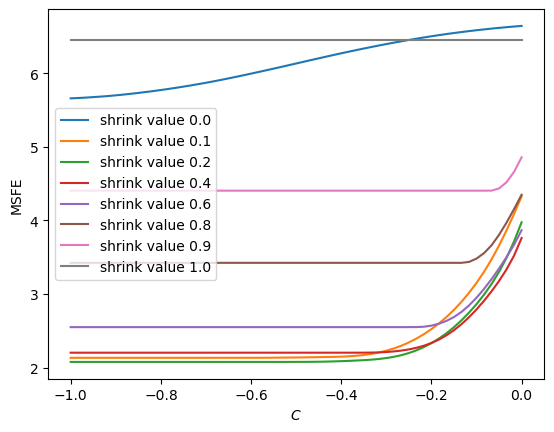

In [154]:
plot_msfe_shrnk(All_Vmsfe,c,shrink_values,n,n_forecasters,phi)

This plot is discussed in detail in the thesis. Both the L2-norm as the plot indicates that a shrinkage parameter of $\delta=0.2$, performance best.

<div style="text-align:center">
  <h3>Simulation study of several covariance estimation methods</h3>
</div>

In this simulation study, the aim is to determine the performance of different covariance estimation methods. Especially, the sample covariance method, the linear shrinkage method and the factor model. The details of these methods have already been discussed in this Notebook. In the previous simulation study, an optimal shrinkage parameter of $\delta=0.2$ is found. This will be the parameter used in this simulation study. 

The simulation itself is similar to the previous one. With the same characteristics and parameters. As stated the shrinkage parameter is set at $\delta=0.2$. Furthermore, this time the factor model covaraince matrix is included. This results to: 

- $\phi_1 = -0.95$
- $T = 30$
- $-1<c<0$
- $\delta = 0.2$
- $n = 20000$

In [155]:
def weight_cov_estimation(Merror, Vw_sample, true_cov, type_cov, Mcov_sample, shrink_value):
    """
    Estimate the weight covariance using different covariance estimation methods.

    Input:
        Merror (array): Array of forecast errors.
        Vw_sample (array): Array of weights determined by the sample covariance matrices.
        true_cov (array): True covariance matrix.
        type_cov (int): Type of covariance estimation method to be used.
        Mcov_sample (array): Array of covariance matrix estimations.
        shrink_value (float): Shrinkage value.

    Returns:
        Vw (array): Array of weights detemined by covariance matrix estimates.

    """
    n = len(Mcov_sample[0][0])   # Define the number of simulations
    n_forc = len(true_cov)       # The number of forecasts used
    Vw = np.empty((0, n_forc))
    l2_norm = np.zeros(n)

    for i in range(n):          
        # Create a single Merror for every n with the forecast errors
        Merror_single = [matrix[i] for matrix in Merror] 
        Merror_single = np.vstack(Merror_single)

        if type_cov == 0:
            # Use the simple covariance matrix earlier determined
            Mcov = np.array([[element[i] for element in row] for row in Mcov_sample])
            w = Vw_sample[i]
        elif type_cov == 1:
            # Estimate covariance matrix using shrinkage
            Mcov_temp = np.array([[element[i] for element in row] for row in Mcov_sample])
            Mcov, w = est_cov_shrinkage(Mcov_temp, shrink_value)
        elif type_cov == 2:
            # Estimate covariance matrix using factor analysis
            Mcov, w = est_cov_factor(Merror_single)

        Vw = np.vstack((Vw, w.T))
        l2_norm[i] = np.linalg.norm(true_cov - Mcov)

    print('Covariance estimation type:', type_cov)
    print('l2_norm:', np.round(np.mean(l2_norm), 4))
    return Vw

In [156]:
def calc_msfe2(c, phi, T, n, n_forecasters, true_cov, type_cov, shrink_value):
    """
    Calculate the MSFE using weights determined by different covariance matrix estimation methods.

    Input:
        c (array): Array of threshold values.
        phi (float): Autoregressive coefficient for the AR(1 process).
        T (int): Number of observations for estimating the forecast error. If put T = 30, it will result in the same number
                 of observation as seen in the simulation of Radchenko et al. (2023), 28
        n (int): Number of simulations.
        n_forecasters (int): Number of forecasters.
        true_cov (array): True covariance matrix.
        type_cov (array): Array of covariance estimation types.
        shrink_value (float): Shrinkage value.

    Returns:
        All_Vmsfe (array): Array of MSFE values for each threshold and covariance estimation method.
        
    """
    rho2 = phi ** 2
    z = simulate_ar1(phi, T, n, n_forecasters)
    zf = [z[-1] for z in z]  # The T+1 value to be forecasted
    z = np.delete(z, -1, axis=1)
    Vy, VY, Merror, mu = calc_forecast_errors(z, rho2, n_forecasters)
    Mcov_sample, Vw_sample = est_cov_sample(Merror)
    All_Vmsfe = np.empty((0, len(c)))

    for k in range(len(type_cov)):
        vW = weight_cov_estimation(Merror, Vw_sample, true_cov, type_cov[k], Mcov_sample, shrink_value)
        vW = vW.T
        Vmsfe = np.empty(len(c))

        for i in range(len(c)):
            Vw_trimmed = np.where(vW < c[i], c[i], vW)
            Vw_normalized = np.divide(Vw_trimmed, sum(Vw_trimmed))
            yc2 = calc_comb_forecast(Vy, Vw_normalized)
            error = np.power((zf - yc2), 2)
            Vmsfe[i] = np.mean(error)

        All_Vmsfe = np.vstack((All_Vmsfe, Vmsfe.T))

    return All_Vmsfe

In [157]:
phi = -0.95
T = 30
c = np.linspace(-1, 0, 61)
n = 20000
n_forecasters = 25
shrink_value =  0.2
true_cov = calc_true_cov(phi,n_forecasters)
type_cov = [0,1,2]
All_Vmsfe2 = calc_msfe2(c,phi,T,n,n_forecasters,true_cov,type_cov,shrink_value)

Covariance estimation type: 0
l2_norm: 131.3961
Covariance estimation type: 1
l2_norm: 122.6323
Covariance estimation type: 2
l2_norm: 191.4751


The MSFE functions will be plotted as well.

In [158]:
def plot_msfe_methods(Vmsfe, c, n, n_forecasters, phi, methods):
    """
    Plot the MSFE using different covariance estimation methods.

    Input:
        Vmsfe (array): Array of MSFE values.
        c (array): Array of threshold values.
        n (int): Number of simulations.
        n_forecasters (int): Number of forecasters.
        phi (float): AR(1) parameter.
        methods (array): Array of covariance estimation methods.

    Returns:
        None

    """
    fig, ax = plt.subplots()
    for i, array in enumerate(Vmsfe):
        ax.plot(c, array, label=methods[i])

    ax.set_xlabel('$C$')
    ax.set_ylabel('MSFE')
    plt.legend(loc='center left', bbox_to_anchor=(0.001, 0.63))
    plt.title('MSFE Plot N:%d forecasters:%d phi:%.2f' % (n, n_forecasters, phi))
    plt.show()

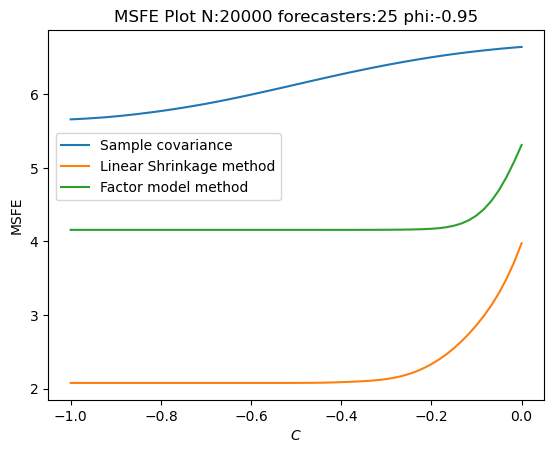

In [159]:
methods = ['Sample covariance','Linear Shrinkage method','Factor model method' ]
plot_msfe_methods(All_Vmsfe2,c,n,n_forecasters,phi,methods)

All these results are evaluated in detail in the thesis.